# Mini-projet Machine Learning
donné par Quinten (28/02/2019)

---

__Scénario__ :

Notre client, un hôpital, désire optimiser le processus de diagnostic de la Leucémie Lymphoïde Chronique (LLC), maladie cancéreuse qui se traduit par une prolifération monoclonale de lymphocytes B qui vont envahir progressivement le sang. Pour ce faire cet hôpital dispose de données issues de la spectrométrie Raman.

<img src="img/spectrometer.png" width="600" />

Le spectromètre Raman pointe sur trois régions aléatoires d’une cellule et génère les spectres associés à chacun de ces points : 

<img src="img/spectrum.png" width="600" />

Les spectres passent ensuite une série de contrôles de qualité :

« The spectral data are pre-processed for correction of spectral interferences [...]. Such pre-processed spectra are submitted to quality tests such as signal to noise ratio, spikes. Spectra fulfilling these quality tests are kept for further numerical/statistical analysis »

Uniquement les spectres passant les contrôles sont conservés, conduisant à un nombre différent de cellules par patient et de spectres par cellule.

L’objectif de ce cas technique est de développer un algorithme permettant de diagnostiquer la LLC en estimant la proportion de cellules B pour un patient donné et qui sera utilisé par l’hôpital pour assister le travail des laborantins.


__Données__ :

►	raw_data.csv : une table en 1 ligne par spectre, répertoriant les informations suivantes :

- patient_name : Identifiant unique du patient (identifiant du patient)
- cell_name : Identifiant unique de la cellule (identifiant de la cellule)
- cell_type : type de la cellule (lymphocyte B ou lymphocyte TNK)
- patient_state: Booléen : état du patient (malade ou sain)
- spectre : numéro du spectre pour une cellule donnée (identifiant arbitraire du spectre)
- lambda_1 à lambda_999 : amplitude mesurée pour chaque longueur d’onde.


__Objectifs__ :

Dans ce cadre, nous vous demandons de détailler les éléments suivants :
1.	Analyse descriptive des données et les conclusions que vous en tirez
2.	Méthodologie de la structuration des données effectuée
3.	Détail des algorithmes et stratégies analytiques envisagée et retenue
4.	Présentation synthétique des résultats obtenus et des recommandations associées


---

Librairies utiles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Analyse des données

### Chargement des données

In [2]:
with open("raw_data.csv", "r") as f:
    data = pd.read_csv(f, delimiter=";")
data.head()

,patient_name,cell_name,cell_type,patient_state,lambda_1,lambda_2,lambda_3,lambda_4,lambda_5,lambda_6,...,lambda_991,lambda_992,lambda_993,lambda_994,lambda_995,lambda_996,lambda_997,lambda_998,lambda_999,spectre
0,P2_ULC80,P2_ULC80_M1_L1_ROI1_C1,B,malade,86.256404,84.116425,83.269485,73.725729,69.172432,58.695397,...,345.330540,343.913899,340.570137,336.092245,329.088472,324.055107,314.110388,319.853392,335.922163,3.0
1,P2_ULC80,P2_ULC80_M1_L1_ROI1_C1,B,malade,72.367814,70.946072,73.946121,69.342146,66.510280,51.961781,...,329.497317,330.293120,334.239066,336.958602,332.810752,337.041213,329.390541,317.220241,289.615842,2.0
2,P2_ULC80,P2_ULC80_M1_L1_ROI1_C1,B,malade,36.107124,50.509171,61.251275,60.634079,59.005082,43.374480,...,349.773008,362.963878,377.543505,369.898047,347.525042,324.241500,304.862554,313.958545,356.180451,1.0
3,P2_ULC80,P2_ULC80_M1_L1_ROI1_C2,B,malade,75.073652,57.880571,53.339291,47.543917,51.896103,40.910901,...,316.498420,323.193044,321.317859,310.282294,326.497336,339.002563,345.054206,372.404114,414.603390,2.0
4,P2_ULC80,P2_ULC80_M1_L1_ROI1_C2,B,malade,51.591270,54.161436,63.649577,58.364222,61.095665,47.811723,...,324.027328,320.147621,318.339477,310.159782,313.315257,333.873758,339.270424,352.541981,351.914705,1.0


### Analyses

In [3]:
print("Nombre de patients :", len(data["patient_name"].unique()))

Nombre de patients : 33


Nombre de cellules par patient :
en moyenne : 218.0909090909091


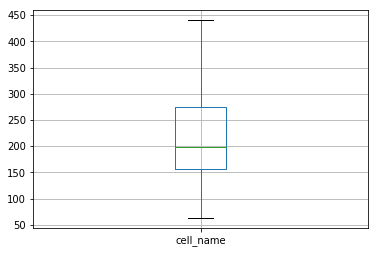

In [4]:
print("Nombre de cellules par patient :")
cell_per_pat = data[["patient_name","cell_name"]].groupby("patient_name").count()
print("en moyenne :", cell_per_pat.mean()["cell_name"])
cell_per_pat.boxplot()


In [5]:
print("Répartition du nombre de spectres par cellule :")
print(data[["cell_name", "spectre"]].groupby("cell_name").count()["spectre"].value_counts()) 

Répartition du nombre de spectres par cellule :
3    2209
2     211
1     148
Name: spectre, dtype: int64


In [6]:
print("Répartition des cellules en fonction du statut :")
data["patient_state"].value_counts()/len(data)

Répartition des cellules en fonction du statut :


sain      0.620536
malade    0.379464
Name: patient_state, dtype: float64

In [7]:
print("Répartition des patients selon leur statut :")
data[["patient_name", "patient_state"]].drop_duplicates()["patient_state"].value_counts()/33

Répartition des patients selon leur statut :


sain      0.575758
malade    0.424242
Name: patient_state, dtype: float64

Rq : Label particulièrement déséquilibré, trop de patients sains (presque double) par rapport au nombre de patients malades

count
patient_state cell_type          
malade        B          0.831564
              TNK        0.168436
sain          B          0.142633
              TNK        0.857367

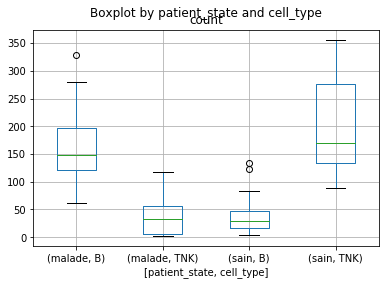

In [41]:
tmp = data[["patient_name", "cell_type", "patient_state", "cell_name"]].groupby(["patient_name", "patient_state", "cell_type"]).count().rename(columns={"cell_name":"count"})
tmp.boxplot(by=["patient_state", "cell_type"])
plt.suptitle("Boxplot by patient_state and cell_type")
tmp1 = tmp.groupby(["patient_state"]).sum()
tmp2 = tmp.groupby(["patient_state","cell_type"]).sum()
tmp2/tmp1

On remarque dans ce tableau que les patients malades ont en moyenne beaucoup plus de lymphocytes B que de lymphocytes TNK contrairement aux patients sains.

Néanmoins, cette première hypothèse peut s'avérer fausse car le nombre de cellules analysées par patient n'est pas le même. Il se pourrait donc que pour certains patients, un type de cellule ait été plus tiré que l'autre. Le nombre de cellules de chaque type donne donc une première idée mais n'est pas fiable.

Analyse des lambdas

In [9]:
lambdas = ["lambda_{}".format(i) for i in range(1,999)]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B79FBB33C8>,
      dtype=object)

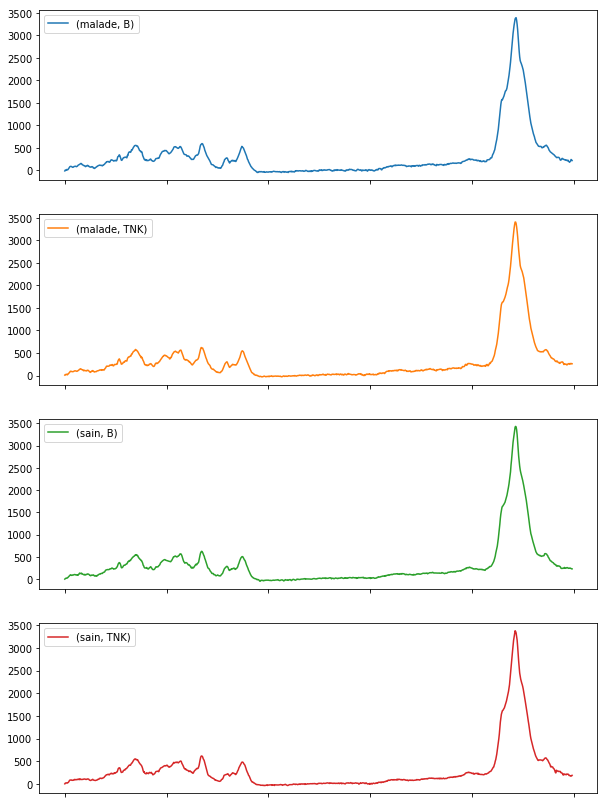

In [10]:
data[["patient_state", "cell_type", *lambdas]].groupby(["patient_state", "cell_type"]).min().T.plot(subplots=True,figsize=(10,16))

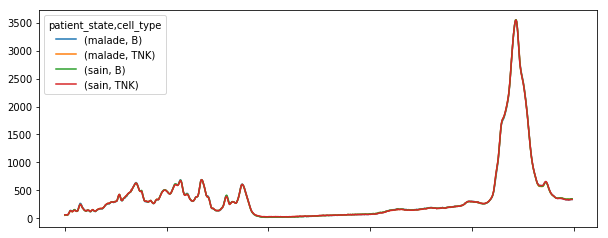

In [13]:
data[["patient_state", "cell_type", *lambdas]].groupby(["patient_state", "cell_type"]).mean().T.plot(figsize=(10,4))

C:\Users\Steban\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Steban\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


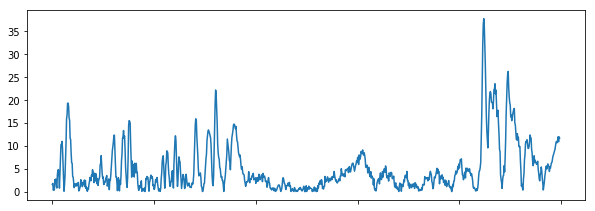

In [9]:
B_sain = data[data["cell_type"]=="B"][data["patient_state"]=="sain"][[*lambdas]].mean()
B_malade = data[data["cell_type"]=="B"][data["patient_state"]=="malade"][[*lambdas]].mean()
(B_sain - B_malade).abs().plot(figsize=(10,3.5))

C:\Users\Steban\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Steban\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


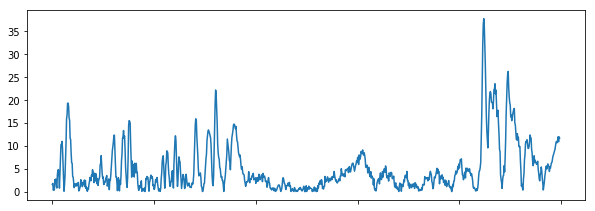

In [10]:
TNK_sain = data[data["cell_type"]=="B"][data["patient_state"]=="sain"][[*lambdas]].mean()
TNK_malade = data[data["cell_type"]=="B"][data["patient_state"]=="malade"][[*lambdas]].mean()
(TNK_sain - TNK_malade).abs().plot(figsize=(10,3.5))

Affichage logarithmique pour réduire les écarts et mieux distinguer les différences

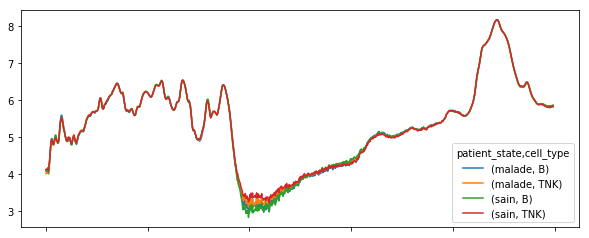

In [11]:
tmp = data[["patient_state", "cell_type", *lambdas]].groupby(["patient_state", "cell_type"]).mean()
for att in tmp:
    tmp[att] = np.log(tmp[att])
tmp.T.plot(figsize=(10,4))

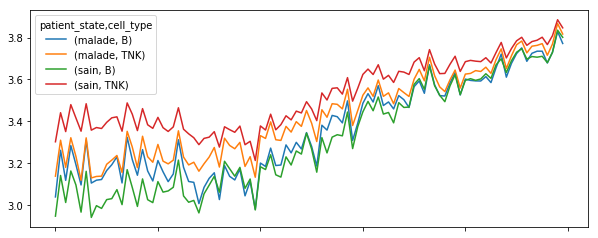

In [24]:
tmp = data[["patient_state", "cell_type", *lambdas[400:500]]].groupby(["patient_state", "cell_type"]).mean()
for att in tmp:
    tmp[att] = np.log(tmp[att])
tmp.T.plot(figsize=(10,4))

## Structuration des données

__Feature engineering__ :

$\to$ Pour un patient :
- Pourcentage de lymphocytes B : _Risqué_
- Pourcentage de lymphocytes TNK : _Risqué_
- log lambdas moyens des lymphocytes B : _Et les patients pour lesquels ou y a pas ?_
- log lambdas moyens des lymphocytes TNK : _Meme chose que pour les lymphocytes B_

$\to$ Label : patient_state

Formatage des données

__Problème__ :

Certains patients n'ont pas de cellules B ou TNK qui ont été analysés.

- Peut-on se fier à la proportion des cellules analysés ?
- Comment faire pour les cellules d'un type lorsqu'elles n'ont pas été analysées pour un patient ?

In [5]:
# Pourcentage de lymphocytes B
feat1_tmp1 = data[["patient_name", "cell_name"]].groupby("patient_name").count()
feat1_tmp2 = data[data["cell_type"]=="B"][["patient_name", "cell_name"]].groupby("patient_name").count()
feat1 = (feat1_tmp2/feat1_tmp1)
# Pas de lymphocytes B qui ont été analysés pour certains patients
feat1 = feat1.fillna(0).rename(columns={"cell_name":"prop_B"})
feat1

,prop_B
patient_name,
P1_ULC100,0.022989
P1_ULC101,0.083799
P1_ULC103,0.000000
P1_ULC106,0.000000
P1_ULC127,0.210280
P1_ULC133,0.082011
P1_ULC137,0.109489
P1_ULC138,0.302273
P1_ULC144,0.075325


In [6]:
# Pourcentage de lymphocytes TNK
feat2_tmp1 = data[["patient_name", "cell_name"]].groupby("patient_name").count()
feat2_tmp2 = data[data["cell_type"]=="TNK"][["patient_name", "cell_name"]].groupby("patient_name").count()
feat2 = (feat2_tmp2/feat2_tmp1)
feat2 = feat2.fillna(0).rename(columns={"cell_name":"prop_TNK"})
feat2

,prop_TNK
patient_name,
P1_ULC100,0.977011
P1_ULC101,0.916201
P1_ULC103,1.000000
P1_ULC106,1.000000
P1_ULC127,0.789720
P1_ULC133,0.917989
P1_ULC137,0.890511
P1_ULC138,0.697727
P1_ULC144,0.924675


In [7]:
# log lambdas moyens des lymphocytes
feat3 = data[["patient_name", *lambdas]].groupby("patient_name").mean()
for att in feat3:
    feat3[att] = np.log(feat3[att])
feat3

,lambda_1,lambda_2,lambda_3,lambda_4,lambda_5,lambda_6,lambda_7,lambda_8,lambda_9,lambda_10,...,lambda_989,lambda_990,lambda_991,lambda_992,lambda_993,lambda_994,lambda_995,lambda_996,lambda_997,lambda_998
patient_name,,,,,,,,,,,,,,,,,,,,,
P1_ULC100,4.363909,4.399072,4.382115,4.381182,4.375839,4.416078,4.455341,4.543631,4.650750,4.762867,...,5.737480,5.738065,5.743267,5.744751,5.749294,5.751100,5.758760,5.762331,5.766700,5.769530
P1_ULC101,4.176961,4.146773,4.120421,4.141028,4.188381,4.093534,4.220848,4.346384,4.515292,4.676905,...,5.681471,5.683556,5.666045,5.674748,5.664077,5.667313,5.666542,5.671170,5.666988,5.669631
P1_ULC103,4.144882,4.122861,4.133452,4.120779,4.171586,4.064739,4.222440,4.352827,4.483874,4.682510,...,5.712405,5.715978,5.696366,5.708714,5.696785,5.707533,5.706481,5.718059,5.718105,5.715808
P1_ULC106,4.019228,3.997561,4.004364,4.039851,4.110415,3.947601,4.102075,4.240447,4.415188,4.606804,...,5.807104,5.809465,5.786290,5.801956,5.795166,5.803971,5.810812,5.821594,5.818544,5.816340
P1_ULC127,4.015349,4.011904,3.994208,4.028177,4.092011,3.970010,4.135694,4.283429,4.502016,4.697145,...,5.862157,5.864049,5.845063,5.857607,5.854529,5.860877,5.870030,5.882826,5.885378,5.886868
P1_ULC133,3.978998,3.931364,3.872967,3.931337,4.022844,3.893175,4.072362,4.231992,4.453433,4.634843,...,5.839683,5.843889,5.818017,5.835571,5.834737,5.843379,5.847413,5.854005,5.849770,5.849445
P1_ULC137,4.141568,4.172960,4.174499,4.207694,4.236161,4.150799,4.259016,4.385040,4.575686,4.744110,...,5.861671,5.867164,5.855966,5.865507,5.864826,5.871137,5.877792,5.885485,5.888583,5.888717
P1_ULC138,4.114132,4.149660,4.114377,4.111195,4.116950,4.091792,4.200139,4.365769,4.520106,4.723374,...,5.878730,5.886222,5.881246,5.886203,5.878840,5.884351,5.889916,5.893158,5.902152,5.900403
P1_ULC144,3.995504,3.994181,3.957685,4.010814,4.077161,3.927895,4.085629,4.236935,4.427504,4.614676,...,5.867827,5.878246,5.854385,5.870243,5.865526,5.876078,5.881177,5.895610,5.899748,5.904026


In [8]:
# Rassemblement des informations
sdata = feat1.merge(feat2, on="patient_name").merge(feat3, on="patient_name").merge(data[["patient_name","patient_state"]], on="patient_name").drop_duplicates()
# Transformation des labels : 0 sain, 1 malade
sdata["patient_state"] = sdata["patient_state"].replace("sain", 0)
sdata["patient_state"] = sdata["patient_state"].replace("malade", 1)
sdata

,patient_name,prop_B,prop_TNK,lambda_1,lambda_2,lambda_3,lambda_4,lambda_5,lambda_6,lambda_7,...,lambda_990,lambda_991,lambda_992,lambda_993,lambda_994,lambda_995,lambda_996,lambda_997,lambda_998,patient_state
0,P1_ULC100,0.022989,0.977011,4.363909,4.399072,4.382115,4.381182,4.375839,4.416078,4.455341,...,5.738065,5.743267,5.744751,5.749294,5.751100,5.758760,5.762331,5.766700,5.769530,0
174,P1_ULC101,0.083799,0.916201,4.176961,4.146773,4.120421,4.141028,4.188381,4.093534,4.220848,...,5.683556,5.666045,5.674748,5.664077,5.667313,5.666542,5.671170,5.666988,5.669631,0
353,P1_ULC103,0.000000,1.000000,4.144882,4.122861,4.133452,4.120779,4.171586,4.064739,4.222440,...,5.715978,5.696366,5.708714,5.696785,5.707533,5.706481,5.718059,5.718105,5.715808,0
441,P1_ULC106,0.000000,1.000000,4.019228,3.997561,4.004364,4.039851,4.110415,3.947601,4.102075,...,5.809465,5.786290,5.801956,5.795166,5.803971,5.810812,5.821594,5.818544,5.816340,0
540,P1_ULC127,0.210280,0.789720,4.015349,4.011904,3.994208,4.028177,4.092011,3.970010,4.135694,...,5.864049,5.845063,5.857607,5.854529,5.860877,5.870030,5.882826,5.885378,5.886868,0
754,P1_ULC133,0.082011,0.917989,3.978998,3.931364,3.872967,3.931337,4.022844,3.893175,4.072362,...,5.843889,5.818017,5.835571,5.834737,5.843379,5.847413,5.854005,5.849770,5.849445,0
1132,P1_ULC137,0.109489,0.890511,4.141568,4.172960,4.174499,4.207694,4.236161,4.150799,4.259016,...,5.867164,5.855966,5.865507,5.864826,5.871137,5.877792,5.885485,5.888583,5.888717,0
1406,P1_ULC138,0.302273,0.697727,4.114132,4.149660,4.114377,4.111195,4.116950,4.091792,4.200139,...,5.886222,5.881246,5.886203,5.878840,5.884351,5.889916,5.893158,5.902152,5.900403,0
1846,P1_ULC144,0.075325,0.924675,3.995504,3.994181,3.957685,4.010814,4.077161,3.927895,4.085629,...,5.878246,5.854385,5.870243,5.865526,5.876078,5.881177,5.895610,5.899748,5.904026,0
2231,P1_ULC147,0.204380,0.795620,4.059883,4.054886,4.023685,4.036596,4.097502,3.985580,4.139713,...,5.842057,5.816313,5.839478,5.838497,5.847737,5.854555,5.863195,5.856810,5.863224,0


In [9]:
y = sdata["patient_state"].values
X = sdata.drop(columns=["patient_name", "patient_state"]).values

In [10]:
X, y

(array([[0.02298851, 0.97701149, 4.36390893, ..., 5.76233108, 5.76669969,
         5.76952983],
        [0.08379888, 0.91620112, 4.17696094, ..., 5.67117013, 5.66698801,
         5.66963115],
        [0.        , 1.        , 4.14488229, ..., 5.71805941, 5.71810525,
         5.71580843],
        ...,
        [0.92783505, 0.07216495, 4.08828547, ..., 5.73392047, 5.73481492,
         5.74432543],
        [0.98461538, 0.01538462, 4.16220476, ..., 5.7605481 , 5.75093662,
         5.75442125],
        [0.96825397, 0.03174603, 4.16749263, ..., 5.58474708, 5.56218033,
         5.55165399]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))

## Algorithmes et stratégies analytiques

Vu le peu de patients que nous avons comme référence, procédons à une cross validation pour une meilleure évaluation, plus précisément un Leave-one-out utilisé fréquemment dans le domaine de la santé.

In [58]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
loo.get_n_splits(X, y)

33

In [59]:
def loo_eval(classifier):
    scores = []
    for train, test in loo.split(X, y):
        scores.append( classifier.fit(X[train], y[train]).score(X[test], y[test]) )
    return np.mean(scores)

Librairies pour régulariser

In [81]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

def tests(classifier, name):
    print(name, ":", loo_eval( classifier ) )
    print(name, "+ StandardScaler :", loo_eval( Pipeline(steps=[("scale", StandardScaler()), ("model", classifier)]) ))
    print(name, "+ MinMaxScaler :", loo_eval( Pipeline(steps=[("scale", MinMaxScaler()), ("model", classifier)]) ))

### Modèles linéaires

In [86]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import LinearSVC

Perceptron

In [84]:
classifier = Perceptron()
tests(classifier, "Perceptron")

Perceptron : 0.5757575757575758
Perceptron + StandardScaler : 0.5454545454545454
Perceptron + MinMaxScaler : 0.6666666666666666


Régression logistique

In [85]:
classifier = LogisticRegression()
tests(classifier, "Régression logistique")

Régression logistique : 0.9090909090909091
Régression logistique + StandardScaler : 0.6060606060606061
Régression logistique + MinMaxScaler : 0.7575757575757576


SVM linéaire

In [87]:
classifier = LinearSVC()
tests(classifier, "SVM linéaire")

SVM linéaire : 0.5757575757575758
SVM linéaire + StandardScaler : 0.6060606060606061
SVM linéaire + MinMaxScaler : 0.7878787878787878


### Modèles plus complexe

Arbre de décision

In [93]:
from sklearn.tree import DecisionTreeClassifier

# On recherche d'abord la profondeur optimale (hyperparemètre)
for i in range(1, 10):
    print("--- Profondeur :", i)
    classifier = DecisionTreeClassifier(max_depth=i)
    tests(classifier, "Arbre de décision")
    

--- Profondeur : 1
Arbre de décision : 0.9393939393939394
Arbre de décision + StandardScaler : 0.9393939393939394
Arbre de décision + MinMaxScaler : 0.9393939393939394
--- Profondeur : 2
Arbre de décision : 0.8787878787878788
Arbre de décision + StandardScaler : 0.8787878787878788
Arbre de décision + MinMaxScaler : 0.9090909090909091
--- Profondeur : 3
Arbre de décision : 0.8787878787878788
Arbre de décision + StandardScaler : 0.9393939393939394
Arbre de décision + MinMaxScaler : 0.9090909090909091
--- Profondeur : 4
Arbre de décision : 0.9090909090909091
Arbre de décision + StandardScaler : 0.9090909090909091
Arbre de décision + MinMaxScaler : 0.9090909090909091
--- Profondeur : 5
Arbre de décision : 0.9393939393939394
Arbre de décision + StandardScaler : 0.8787878787878788
Arbre de décision + MinMaxScaler : 0.9090909090909091
--- Profondeur : 6
Arbre de décision : 0.9393939393939394
Arbre de décision + StandardScaler : 0.9393939393939394
Arbre de décision + MinMaxScaler : 0.909090909

SVM avec noyau

In [96]:
from sklearn.svm import SVC

classifier = SVC(max_iter=700, kernel="rbf")
tests(classifier, "SVM noyau RBF")
print("---")
classifier = SVC(max_iter=700, kernel="poly")
tests(classifier, "SVM noyau polynomial")
print("---")
classifier = SVC(max_iter=700, kernel="sigmoid")
tests(classifier, "SVM noyau sigmoide")

SVM noyau RBF : 0.5757575757575758
SVM noyau RBF + StandardScaler : 0.5454545454545454
SVM noyau RBF + MinMaxScaler : 0.5757575757575758
---
SVM noyau polynomial : 0.9393939393939394
SVM noyau polynomial + StandardScaler : 0.6060606060606061
SVM noyau polynomial + MinMaxScaler : 0.5757575757575758
---
SVM noyau sigmoide : 0.5757575757575758
SVM noyau sigmoide + StandardScaler : 0.6666666666666666
SVM noyau sigmoide + MinMaxScaler : 0.5757575757575758


### Modèles ensemblistes

Utilisons un gridsearch pour trouver les hyperparamètres optimaux

In [97]:
from sklearn.grid_search import GridSearchCV

Forêts aléatoires

In [123]:
from sklearn.ensemble import RandomForestClassifier

parameters = {"n_estimators":list(range(1,30)), "max_depth":list(range(1,7))}
clf = GridSearchCV(RandomForestClassifier(), parameters)
clf.fit(X, y)
clf.best_estimator_, clf.best_params_, clf.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=1, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 {'max_depth': 1, 'n_estimators': 5},
 0.9393939393939394)

In [161]:
classifier = RandomForestClassifier(n_estimators=10, max_depth=1)
tests(classifier, "Forets aléatoires")

Forets aléatoires : 0.7272727272727273
Forets aléatoires + StandardScaler : 0.6060606060606061
Forets aléatoires + MinMaxScaler : 0.6363636363636364


Boosting

In [164]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {"n_estimators":list(range(1,100))}
clf = GridSearchCV(AdaBoostClassifier(), parameters)
clf.fit(X, y)
clf.best_estimator_, clf.best_params_, clf.best_score_

(AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=1.0, n_estimators=1, random_state=None),
 {'n_estimators': 1},
 0.9696969696969697)

In [172]:
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier(n_estimators=1)
tests(classifier, "Adaboost")

Adaboost : 0.9393939393939394
Adaboost + StandardScaler : 0.9393939393939394
Adaboost + MinMaxScaler : 0.9393939393939394
